# Median House Value Assesment Activity

This California Housing Prices dataset has been downloaded from StatLib repository (http://lib.stat.cmu.edu/datasets/). It is based on data from the 1990 California census, what is not important for deep learning. The original dataset appeared in R. Kelley Pace and Ronald Barry, “Sparse Spatial Autoregressions,” Statistics & Probability Letters 33, no. 3 (1997): 291–297.

<b>MedianHouseValuePreparedCleanAttributes.csv</b><br>The original dataset contained 20,640 instances, which is cleaned, preprocessed and prepared in this notebook. After this phase of data preparation, a final dataset of 20,433 instances are obtained with 8 attributes individually normalized with a min-max scaling, $\frac{x-min}{max-min}$ (InputsMedianHouseValueNormalized.csv): $longitude$ and $latitude$ (location), $median age$, $total rooms$, $total bedrooms$, $population$, $households$ and $median income$.  

From this data, the classification problem consists on estimating the median house value, categorized into the following 10 clases (price intervals in thousand dollards): [15.0, 82.3], [82.4, 107.3], [107.4, 133.9], [134.0, 157.3], [157.4, 179.7], [179.8, 209.4], [209.5, 241.9], [242.0, 290.0], [290.1, 376.6] and [376.7, 500.0]. Each class is labelled from 0 (the cheapest) to 9 (the most expensive), and one-hot encoded in <b>MedianHouseValueOneHotEncodedClasses.csv</b> file.

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [31]:
%run 1.ReadingData.py

x_train: (16346, 8)
t_train: (16346, 10)
x_dev: (2043, 8)
t_dev: (2043, 10)
x_test: (2044, 8)
t_test: (2044, 10)


## Initialization

In [32]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1))
NUM_TEST_EXAMPLES = int (round (x_test.shape[0]/1))

Some data is displayed to test the correctness:

In [33]:
INPUTS #Should be 8

8

In [34]:
OUTPUTS #Should be 10

10

In [35]:
NUM_TRAINING_EXAMPLES #16346

16346

In [36]:
NUM_DEV_EXAMPLES #2043

2043

In [37]:
NUM_TEST_EXAMPLES #2044

2044

In [38]:
x_train[:5]

array([[-0.50996016,  0.01381509,  0.80392157, -0.84821201, -0.80571074,
        -0.92174669, -0.79871732, -0.55233721],
       [-0.5059761 ,  0.0053135 , -0.41176471, -0.83234142, -0.8603352 ,
        -0.91373077, -0.86120704, -0.14394284],
       [-0.55577689,  0.1370882 ,  0.1372549 , -0.835953  , -0.77281192,
        -0.92953838, -0.77536589, -0.4999931 ],
       [ 0.39442231, -0.70031881,  0.05882353, -0.91617071, -0.93513346,
        -0.96894532, -0.93093241, -0.01197225],
       [ 0.21713147, -0.70244421,  0.60784314, -0.98077217, -0.96741155,
        -0.9771294 , -0.96743957, -0.93509055]])

In [39]:
t_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [40]:
x_dev[:5]

array([[ 0.33665339, -0.67693943,  0.64705882, -0.96128999, -0.93234016,
        -0.95246504, -0.93520802, -0.83044372],
       [ 0.1812749 , -0.68544102,  0.29411765, -0.84775421, -0.70794538,
        -0.85296673, -0.68886696, -0.75996193],
       [ 0.12549801, -0.30286929, -0.25490196, -0.76397579, -0.59683426,
        -0.96328372, -0.91909225, -0.73878981],
       [ 0.45418327, -0.98512221, -0.01960784, -0.92059616, -0.91154562,
        -0.93598475, -0.8973853 , -0.53633743],
       [ 0.29880478, -0.65993624, -0.01960784, -0.58024315, -0.6424581 ,
        -0.80621654, -0.6283506 , -0.16892181]])

In [41]:
t_dev[:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [42]:
x_test[:5]

array([[-0.25498008, -0.45589798, -0.37254902, -0.8577242 , -0.80260708,
        -0.88721657, -0.80562407, -0.64777038],
       [-0.59760956,  0.15834219, -0.88235294, -0.79668345, -0.6654252 ,
        -0.91098405, -0.70860056, -0.52950994],
       [ 0.56175299, -0.50903294, -0.45098039, -0.83992065, -0.77901924,
        -0.92836122, -0.84048676, -0.79309251],
       [ 0.28685259, -0.73645058, -0.41176471, -0.67699273, -0.45810056,
        -0.71512655, -0.45798388, -0.67123212],
       [ 0.27689243, -0.7088204 , -0.33333333, -0.55063838, -0.52638113,
        -0.77897363, -0.52310475, -0.29046496]])

In [43]:
t_test[:5]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

## Hyperparameters

Some hyperparameters given as example (they may not be the right ones):

In [261]:
n_epochs = 40000 
learning_rate = 0.3
batch_size = 1000
n_neurons_per_layer = [150,100,50] 

## Build the model: a 8-150-75-50-25-10 deep neural network architecture

In [262]:
X = tf.placeholder (dtype=tf.float32, shape=(None,INPUTS),name="X")
t = tf.placeholder (dtype=tf.float32, shape=(None,OUTPUTS), name="t")

The deep neural network topology is defined: a full-connected 9-150-75-25-10-4 architecture. The <b>ReLU</b> activation function is chosen for the hidden layers and linear logits with <b>softmax for the ouput layer</b>. 

In [263]:
hidden_layers = []
hidden_layers.append(tf.layers.dense (X, n_neurons_per_layer[0], 
                                      activation = tf.nn.relu))
for layer in range(1,len(n_neurons_per_layer)):
    hidden_layers.append(tf.layers.dense (hidden_layers[layer-1], 
                    n_neurons_per_layer[layer], activation = tf.nn.relu))
net_out = tf.layers.dense (hidden_layers[len(n_neurons_per_layer)-1], OUTPUTS)
y = tf.nn.softmax (logits=net_out, name="y")

In [264]:
for layer in range(len(n_neurons_per_layer)): print (hidden_layers[layer])

Tensor("dense_90/Relu:0", shape=(?, 150), dtype=float32)
Tensor("dense_91/Relu:0", shape=(?, 100), dtype=float32)
Tensor("dense_92/Relu:0", shape=(?, 50), dtype=float32)


The $log-loss$, $cross-entropy$ (the sun of log-loss is a loss) and and $cost$ (the mean of cross-entropy) functions:

In [265]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits (labels=t, logits=net_out)
mean_log_loss = tf.reduce_mean (cross_entropy, name="cost")

The training algorithm: gradient descent method with a softmax function at the outputs:

In [266]:
train_step = tf.train.GradientDescentOptimizer (learning_rate).minimize(mean_log_loss)

Model evaluation: accuracy. The percentage of correctly classified instances.

In [267]:
correct_predictions = tf.equal(tf.argmax(y,1),tf.argmax(t,1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

## Execute the 8-150-75-50-25-10 deep neural network with M-BGD

In [ ]:
init = tf.global_variables_initializer()
accuracy_train_history = []
with tf.Session() as sess:
    sess.run(init)
    for epoch in tqdm(range(n_epochs)):
        offset = (epoch * batch_size) % (NUM_TRAINING_EXAMPLES - batch_size)
        sess.run (train_step, feed_dict={X: x_train[offset:(offset+batch_size)],
                                         t: t_train[offset:(offset+batch_size)]})
        accuracy_train_history.append (accuracy.eval(feed_dict=
                                {X: x_train[offset:(offset+batch_size)],
                                 t: t_train[offset:(offset+batch_size)]}))
    accuracy_train = accuracy.eval(feed_dict={X: x_train[:NUM_TRAINING_EXAMPLES],
                                              t: t_train[:NUM_TRAINING_EXAMPLES]})
    accuracy_dev = accuracy.eval(feed_dict={X: x_dev[:NUM_DEV_EXAMPLES],
                                              t: t_dev[:NUM_DEV_EXAMPLES]})
    
    dev_predictions = y.eval(feed_dict={X: x_dev[:NUM_DEV_EXAMPLES]})
    dev_correct_preditions = correct_predictions.eval (feed_dict=
                                    {X: x_dev[:NUM_DEV_EXAMPLES],
                                     t: t_dev[:NUM_DEV_EXAMPLES]})
    train_mean_log_loss = mean_log_loss.eval (feed_dict=
                                            {X: x_train[:NUM_TRAINING_EXAMPLES],
                                              t: t_train[:NUM_TRAINING_EXAMPLES]})
    dev_mean_log_loss = mean_log_loss.eval (feed_dict=
                                            {X: x_dev[:NUM_DEV_EXAMPLES],
                                              t: t_dev[:NUM_DEV_EXAMPLES]})


  2%|█▏                                                                            | 610/40000 [00:07<07:37, 86.19it/s]


  3%|██▎                                                                          | 1230/40000 [00:14<07:23, 87.45it/s]


  5%|███▌                                                                         | 1853/40000 [00:22<07:29, 84.86it/s]


  6%|████▊                                                                        | 2470/40000 [00:29<07:25, 84.21it/s]


  8%|██████                                                                       | 3122/40000 [00:37<07:58, 77.14it/s]


  9%|███████▎                                                                     | 3775/40000 [00:44<06:22, 94.69it/s]


 11%|████████▍                                                                    | 4385/40000 [00:51<07:44, 76.59it/s]


 12%|█████████▌                                                                   | 4993/40000 [00:59<06:56, 84.15it/s]


 14%|██████████▊                                                                  | 5632/40000 [01:06<05:55, 96.69it/s]


 16%|████████████                                                                 | 6267/40000 [01:13<06:56, 80.92it/s]


 17%|█████████████▏                                                               | 6860/40000 [01:21<07:05, 77.81it/s]


 19%|██████████████▎                                                              | 7424/40000 [01:28<07:03, 76.92it/s]


 20%|███████████████▍                                                             | 8014/40000 [01:35<06:56, 76.88it/s]


 22%|████████████████▌                                                            | 8608/40000 [01:43<06:05, 85.91it/s]


 23%|█████████████████▋                                                           | 9219/40000 [01:50<06:14, 82.24it/s]


 24%|██████████████████▊                                                          | 9788/40000 [01:57<06:21, 79.17it/s]


 26%|███████████████████▋                                                        | 10346/40000 [02:05<06:27, 76.56it/s]


 27%|████████████████████▊                                                       | 10922/40000 [02:12<06:05, 79.58it/s]


 29%|█████████████████████▊                                                      | 11496/40000 [02:19<05:23, 88.05it/s]


 30%|██████████████████████▉                                                     | 12102/40000 [02:27<05:44, 80.99it/s]


 32%|████████████████████████▏                                                   | 12722/40000 [02:34<05:46, 78.65it/s]


 33%|█████████████████████████▎                                                  | 13306/40000 [02:41<05:28, 81.17it/s]


 35%|██████████████████████████▍                                                 | 13910/40000 [02:49<05:10, 83.90it/s]


 36%|███████████████████████████▌                                                | 14530/40000 [02:56<05:25, 78.13it/s]


 38%|████████████████████████████▊                                               | 15133/40000 [03:04<04:59, 83.04it/s]


 39%|█████████████████████████████▉                                              | 15730/40000 [03:11<05:06, 79.30it/s]


 41%|███████████████████████████████                                             | 16347/40000 [03:19<05:02, 78.20it/s]


 42%|████████████████████████████████▏                                           | 16957/40000 [03:26<04:31, 84.78it/s]


 44%|█████████████████████████████████▍                                          | 17571/40000 [03:33<04:39, 80.19it/s]


 45%|██████████████████████████████████▌                                         | 18160/40000 [03:41<04:13, 86.21it/s]


 47%|███████████████████████████████████▋                                        | 18759/40000 [03:48<04:35, 77.20it/s]


 48%|████████████████████████████████████▋                                       | 19329/40000 [03:55<04:29, 76.83it/s]


 50%|█████████████████████████████████████▊                                      | 19876/40000 [04:02<04:23, 76.49it/s]


 51%|██████████████████████████████████████▊                                     | 20460/40000 [04:10<03:54, 83.38it/s]


 53%|███████████████████████████████████████▉                                    | 21033/40000 [04:17<04:08, 76.22it/s]


 54%|█████████████████████████████████████████                                   | 21583/40000 [04:24<03:53, 78.91it/s]


 55%|██████████████████████████████████████████                                  | 22149/40000 [04:31<03:52, 76.71it/s]


 57%|███████████████████████████████████████████                                 | 22696/40000 [04:39<03:45, 76.67it/s]


 58%|████████████████████████████████████████████▏                               | 23271/40000 [04:46<03:39, 76.36it/s]


 60%|█████████████████████████████████████████████▎                              | 23874/40000 [04:53<03:14, 82.70it/s]


 61%|██████████████████████████████████████████████▋                             | 24542/40000 [05:01<02:52, 89.50it/s]


 63%|███████████████████████████████████████████████▊                            | 25192/40000 [05:08<02:52, 86.05it/s]


 65%|█████████████████████████████████████████████████                           | 25820/40000 [05:15<02:49, 83.81it/s]


 66%|██████████████████████████████████████████████████▏                         | 26446/40000 [05:23<02:36, 86.35it/s]


 68%|███████████████████████████████████████████████████▍                        | 27044/40000 [05:30<02:38, 81.68it/s]


 69%|████████████████████████████████████████████████████▌                       | 27679/40000 [05:38<02:30, 81.76it/s]


 71%|█████████████████████████████████████████████████████▋                      | 28238/40000 [05:45<02:28, 79.11it/s]


 72%|██████████████████████████████████████████████████████▋                     | 28783/40000 [05:52<02:26, 76.36it/s]


 73%|███████████████████████████████████████████████████████▊                    | 29366/40000 [05:59<02:10, 81.54it/s]


 75%|████████████████████████████████████████████████████████▉                   | 29976/40000 [06:07<01:54, 87.17it/s]


 77%|██████████████████████████████████████████████████████████▏                 | 30601/40000 [06:14<01:45, 88.85it/s]


 78%|███████████████████████████████████████████████████████████▎                | 31225/40000 [06:21<01:44, 84.33it/s]


 80%|████████████████████████████████████████████████████████████▌               | 31843/40000 [06:29<01:35, 84.99it/s]


 81%|█████████████████████████████████████████████████████████████▋              | 32466/40000 [06:36<01:28, 85.45it/s]


 83%|██████████████████████████████████████████████████████████████▊             | 33086/40000 [06:44<01:21, 85.14it/s]


 84%|████████████████████████████████████████████████████████████████            | 33706/40000 [06:51<01:13, 86.08it/s]


 85%|████████████████████████████████████████████████████████████████▌           | 33957/40000 [06:55<01:13, 82.43it/s]

In [250]:
"Accuracy in training: " + str(accuracy_train)

'Accuracy in training: 0.41221094'

In [251]:
"Maximum accuracy in training: " + str(np.max(accuracy_train_history))

'Maximum accuracy in training: 0.539'

In [252]:
"Accuracy for the development set: " + str(accuracy_dev)

'Accuracy for the development set: 0.37591776'

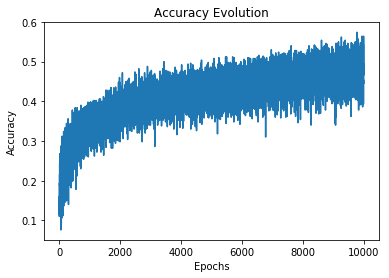

In [241]:
plt.title ("Accuracy Evolution")
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy")
plt.plot (range(n_epochs),accuracy_train_history)

In [79]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:10]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [80]:
t_dev[:10] #target classes

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [81]:
dev_correct_preditions[:10]

array([False, False, False, False, False,  True,  True,  True, False,
        True])

In [82]:
train_mean_log_loss

1.3841131

In [83]:
dev_mean_log_loss

1.6258737

<b>Development accuracy has been raised to 40%</b>. Better results have been achieved using 260 hidden neurons than using a one-hidden layer of 1024 units.

## Test the 8-150-75-50-25-10 deep neural network with M-BGD

In [61]:
init = tf.global_variables_initializer()
accuracy_train_history = []
with tf.Session() as sess:
    sess.run(init)
    for epoch in tqdm(range(n_epochs)):
        offset = (epoch * batch_size) % (NUM_TRAINING_EXAMPLES - batch_size)
        sess.run (train_step, feed_dict={X: x_train[offset:(offset+batch_size)],
                                         t: t_train[offset:(offset+batch_size)]})
            
    
    
    accuracy_test = accuracy.eval(feed_dict={X: x_test[:NUM_TEST_EXAMPLES],
                                              t: t_test[:NUM_TEST_EXAMPLES]})
    test_predictions = y.eval(feed_dict={X: x_test[:NUM_TEST_EXAMPLES]})
    
    test_correct_preditions = correct_predictions.eval (feed_dict=
                                    {X: x_test[:NUM_TEST_EXAMPLES],
                                     t: t_test[:NUM_TEST_EXAMPLES]})   

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 429.25it/s]


In [62]:
"Accuracy for the TEST set: " + str(accuracy_test)

'Accuracy for the TEST set: 0.39823875'

In [63]:
test_predictions

array([[3.50753143e-02, 8.13730806e-02, 1.43453628e-01, ...,
        8.38304088e-02, 5.44100367e-02, 3.01134828e-02],
       [2.04355596e-03, 1.93688693e-03, 1.64919309e-02, ...,
        1.73015833e-01, 7.22645670e-02, 1.92372017e-02],
       [8.19370210e-01, 1.38418958e-01, 2.23084930e-02, ...,
        9.70149064e-04, 3.55190830e-04, 3.54422373e-04],
       ...,
       [6.97389711e-03, 9.32202861e-02, 2.52281576e-01, ...,
        1.43975671e-02, 8.16695392e-03, 3.48961307e-03],
       [9.35807265e-03, 1.35954872e-01, 2.10737497e-01, ...,
        2.35269275e-02, 1.29428701e-02, 3.65918130e-03],
       [4.91485465e-04, 3.66708613e-04, 5.40939067e-03, ...,
        1.36220947e-01, 1.03974104e-01, 5.74184768e-02]], dtype=float32)

In [64]:
test_rounded_predictions=np.round(test_predictions)
indices = np.argmax(test_predictions,1)
for row, index in zip(test_rounded_predictions, indices): row[index]=1
test_rounded_predictions[:10]

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [65]:
t_test[:10] #target classes

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [66]:
test_correct_preditions[:10]

array([ True, False,  True, False, False,  True,  True, False, False,
        True])

Since this is the final neural model, the accuracy is calculated against the final test set, achieving a <b>39.8% of accuracy</b>.